In [1]:
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from utils import *
import time
import matplotlib.pyplot as plt

Epoch: 1 | Batch index: 0 | Batch size: 128
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 128
break minibatch for-loop


In [2]:
class logReg(torch.nn.Module):
    # logistic regression 
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x.float())
        probas = torch.sigmoid(logits)
        return logits, probas

NUM_FEATURES = len(adult.columns)-1
model = logReg(num_features=NUM_FEATURES, num_classes=2)

In [3]:
def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            targets = targets.to(DEVICE).type(torch.LongTensor)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

    
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            try:
                features = features.view(-1, NUM_FEATURES).to(DEVICE)
            except:
                print(features)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

In [4]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.view(-1, NUM_FEATURES).to(DEVICE)
        targets = targets.to(DEVICE).type(torch.LongTensor)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)
    
    train_accuracy = compute_accuracy(model, train_loader)
    test_accuracy = compute_accuracy(model, test_loader)
    
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Train Accuracy: %.3f | Test Accuracy: %.3f' % (train_accuracy, test_accuracy))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


Epoch: 001/020 | Batch 000/255 | Cost: 0.7272
Epoch: 001/020 | Batch 050/255 | Cost: 0.4700
Epoch: 001/020 | Batch 100/255 | Cost: 0.4585
Epoch: 001/020 | Batch 150/255 | Cost: 0.3371
Epoch: 001/020 | Batch 200/255 | Cost: 0.4810
Epoch: 001/020 | Batch 250/255 | Cost: 0.4561
Epoch: 001/020 Train Cost: 0.4013
Train Accuracy: 82.101 | Test Accuracy: 82.292
Time elapsed: 0.03 min
Epoch: 002/020 | Batch 000/255 | Cost: 0.4373
Epoch: 002/020 | Batch 050/255 | Cost: 0.3965
Epoch: 002/020 | Batch 100/255 | Cost: 0.4295
Epoch: 002/020 | Batch 150/255 | Cost: 0.2944
Epoch: 002/020 | Batch 200/255 | Cost: 0.4654
Epoch: 002/020 | Batch 250/255 | Cost: 0.4494
Epoch: 002/020 Train Cost: 0.3836
Train Accuracy: 82.544 | Test Accuracy: 82.771
Time elapsed: 0.05 min
Epoch: 003/020 | Batch 000/255 | Cost: 0.4256
Epoch: 003/020 | Batch 050/255 | Cost: 0.3728
Epoch: 003/020 | Batch 100/255 | Cost: 0.4234
Epoch: 003/020 | Batch 150/255 | Cost: 0.2808
Epoch: 003/020 | Batch 200/255 | Cost: 0.4586
Epoch: 003

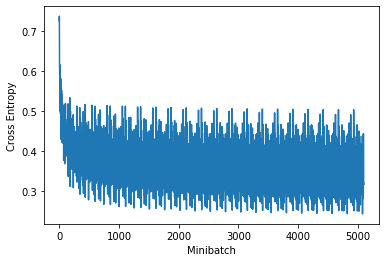

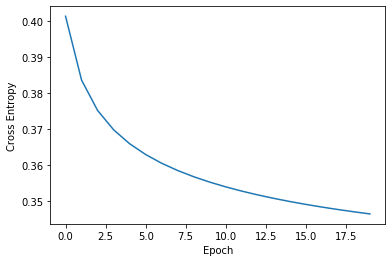

In [5]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()